<h4>All Necessary Imports</h4>

In [1]:
import warnings
import datetime as dt
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder,FunctionTransformer,StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce


***<H3>Dataset Loading & Overview</H3>***

In [2]:
train_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
subm_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {subm_df.shape}")
print("\n=== TRAIN DATA INFO ===")
print(train_df.info())
print("\n=== TEST DATA INFO ===")
print(test_df.info())

Train data shape: (116023, 52)
Test data shape: (29006, 51)
Sample submission shape: (29006, 2)

=== TRAIN DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   tra

### Dataset Loading & Overview

- **Importing CSV Data:**  
  The code uses `pd.read_csv()` from the pandas library to load the train, test, and sample submission datasets from their respective file paths.
  
- **Dataset Shapes:**  
  It prints out the shape (number of rows and columns) for the train, test, and sample submission DataFrames. This gives a quick idea about dataset sizes and whether files loaded as expected.
  
- **Data Structure Information:**  
  The code prints `.info()` for both the train and test DataFrames. This command outputs:
    - Column names and data types
    - Number of non-null entries in each column
    - Memory usage
  This is useful for:
       - Identifying missing values early
        - Understanding datatype distribution (object, int, float)
        - Planning further preprocessing steps
  
**Purpose:**  
 This initial block ensures my data files were loaded correctly, reveals the overall structure and completeness of the data, and sets the stage for effective data cleaning and feature engineering.


***<h3>Column Analysis</h3>***

In [3]:
print(f"Train columns ({len(train_df.columns)}): {list(train_df.columns)}")
print(f"\nTest columns ({len(test_df.columns)}): {list(test_df.columns)}")
print(f"\nSample submission columns: {list(subm_df.columns)}")

train_only = set(train_df.columns) - set(test_df.columns)
test_only = set(test_df.columns) - set(train_df.columns)
print(f"\nColumns only in train: {train_only}")
print(f"Columns only in test: {test_only}")

Train columns (52): ['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 'device.mobileDeviceModel', 'trafficSource.referralPath', 'totals.bounces', 'date', 'devic

### Column Analysis & Comparison

- **Summary of Data Columns:**  
  - Prints the count and list of columns in the train, test, and sample submission DataFrames.
  - This helps quickly check consistency of feature and label columns across datasets.

- **Unique Columns Detection:**  
  - Computes columns that are present only in the train set and not in the test set (`train_only`), and columns present only in the test set and not in the train set (`test_only`).
  - This is useful to:
    - Detect any data leakage risk (e.g., train-only features).
    - Ensure all features required for submission exist in both train and test.
    - Identify columns that may need to be dropped or engineered for consistency.

- **Purpose:**  
  > This block gives an instant overview of the structure and feature alignment across all major files. It’s essential for robust preprocessing, as mismatched column sets can cause errors in model training or inference. It also supports efficient debugging and feature engineering choices.


***<h3>Target Variable Analysis</h3>***

In [4]:
if 'purchaseValue' in train_df.columns:
    target = train_df['purchaseValue']
    print(f"Target variable statistics:")
    print(target.describe())
    
    print(f"\nTarget variable info:")
    print(f"Data type: {target.dtype}")
    print(f"Non-null count: {target.count()}")
    print(f"Null count: {target.isnull().sum()}")
    print(f"Unique values: {target.nunique()}")
    print(f"Min value: {target.min()}")
    print(f"Max value: {target.max()}")
    
    zero_count = (target == 0).sum()
    print(f"Zero values: {zero_count} ({zero_count/len(target)*100:.2f}%)")

Target variable statistics:
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64

Target variable info:
Data type: float64
Non-null count: 116023
Null count: 0
Unique values: 6766
Min value: 0.0
Max value: 23129500000.0
Zero values: 92038 (79.33%)


### Data Cleaning: Removing Constants, Duplicates, and High-NA Columns

- **Remove Constant Columns and Duplicates:**
  - `train = train_df.loc[:, train_df.nunique() != 1].drop_duplicates()`
    - Drops columns in the train and test sets that have only one unique value—these cannot help model learning.
    - Removes duplicate rows to ensure each training example is unique, preventing biases or data leakage.
  - `test = test_df.loc[:, test_df.nunique() != 1]`
    - Applies the same constant column filter to the test set for feature alignment.

- **Drop Columns with Excessive Missing Values:**
  - `threshold_na = 0.5`
    - A threshold of 0.5 means columns with more than 50% missing entries are dropped.
    - This step helps avoid including very sparse features, which can add noise and slow down training.
  - The code retains only columns below this missing ratio in both train and test sets.

- **Manual Feature Removal:**
  - `cols_to_drop = [...]`
    - Explicitly drops select columns (e.g., city, region, metro) that are known to be domain-irrelevant or have high cardinality/low utility.

**Purpose:**  
> This block enforces a clean, reliable, and manageable feature set by removing uninformative columns, duplicated data, and sparsely populated features. These steps prevent modeling errors, reduce computational burden, and improve the overall quality and stability of downstream feature engineering and modeling.


***<h3>Data Types and Sample Values</h3>***

In [5]:
print("=== DATA TYPES AND SAMPLE VALUES ===")

def show_sample_data(df, name, n_samples=3):
    print(f"\n{name} Dataset - First {n_samples} rows:")
    print(df.head(n_samples))
    
    print(f"\n{name} Dataset - Data types summary:")
    dtypes_summary = df.dtypes.value_counts()
    print(dtypes_summary)

show_sample_data(train_df, "TRAIN")
show_sample_data(test_df, "TEST")

=== DATA TYPES AND SAMPLE VALUES ===

TRAIN Dataset - First 3 rows:
  trafficSource.isTrueDirect  purchaseValue browser  \
0                        NaN            0.0    Edge   
1                       True            0.0  Chrome   
2                       True            0.0  Chrome   

         device.screenResolution trafficSource.adContent  \
0  not available in demo dataset                     NaN   
1  not available in demo dataset                     NaN   
2  not available in demo dataset                     NaN   

  trafficSource.keyword screenSize geoCluster  \
0                   NaN     medium   Region_2   
1                   NaN     medium   Region_3   
2        (not provided)     medium   Region_2   

  trafficSource.adwordsClickInfo.slot    device.mobileDeviceBranding  ...  \
0                                 NaN  not available in demo dataset  ...   
1                                 NaN  not available in demo dataset  ...   
2                                 NaN  not

### Data Types & Sample Values Inspection

- **Purpose:**  
  This block defines and uses a function to quickly review the structure, sample content, and data types of my processed DataFrames.

- **Function Description:**
  - `show_sample_data(df, name, n_samples=3)`
    - Prints a header indicating which dataset (`TRAIN` or `TEST`) is being previewed.
    - Displays the first few rows (`n_samples`, default 3) from the DataFrame using `df.head()`, allowing a spot-check of sample values.
    - Prints a summary of data types by counting occurrences of each type (e.g., int64, float64, object) using `df.dtypes.value_counts()`. This helps:
      - Verify if categorical features are encoded.
      - Detect unexpected data types before modeling.
      - Quickly check for obvious data inconsistencies.

- **Usage:**
  - The function is called for both the training and test datasets, ensuring check both sets before moving on to feature engineering or modeling.

**Benefit:**  
> This block gives you a compact, practical snapshot of what your data “looks like under the hood” and how data types are distributed—crucial for debugging preprocessing, planning downstream encoding, and preventing type-related modeling errors.


***<h3>EDA</h3>***

In [6]:
target = train_df['purchaseValue']
print(f"\nTarget Variable Statistics:")
print(f"- Total sessions: {len(target):,}")
print(f"- Purchase sessions: {(target > 0).sum():,}")
print(f"- Purchase rate: {(target > 0).mean():.3f} ({(target > 0).mean()*100:.1f}%)")
print(f"- Average purchase value: ${target.mean():,.2f}")
print(f"- Non-zero average: ${target[target > 0].mean():,.2f}")
print(f"- Target range: ${target.min():,.2f} to ${target.max():,.2f}")


Target Variable Statistics:
- Total sessions: 116,023
- Purchase sessions: 23,985
- Purchase rate: 0.207 (20.7%)
- Average purchase value: $26,563,930.08
- Non-zero average: $128,498,097.14
- Target range: $0.00 to $23,129,500,000.00


### Missing Value Imputation for Categorical and Numerical Features

- **Categorical Feature Imputation:**
  - Iterates through all categorical columns—those with `object` dtype.
  - Replaces missing values with the string `'missing'` in both train and test sets.
    - Ensures no category is left with NaN; prevents errors during encoding.
    - Allows the model to recognize "missingness" as a meaningful value if relevant.

- **Numerical Feature Imputation:**
  - Differentiates between count-like features (`'pageViews'`, `'totalHits'`, `'sessionNumber'`, `'sessionId'`) and other numerical features.
  - For count-like features:
    - Fills all missing values with 0, as missing generally means "no count / no activity recorded."
  - For other numerical features:
    - Fills missing values with the **median** of that column in the training set.
    - Using the median is robust against outliers and is a best practice for numerical data.

**Purpose:**  
> This block systematically fills all missing values in datasets. For categorical columns, it encodes missingness as an explicit category; for numerical columns, it uses context-aware strategies—zero for counts, median for continuous features. This complete imputation is vital for stable and error-free feature engineering and modeling downstream.


***<h3>Data Visualization</h3>***

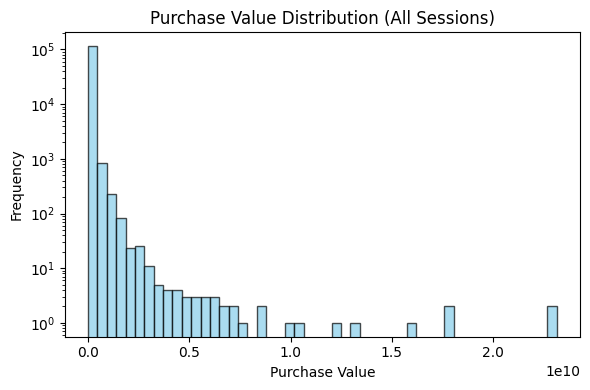

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(target, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Purchase Value Distribution (All Sessions)')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.tight_layout()
plt.show()


**This histogram displays the distribution of purchase values only for sessions with a non-zero purchase.**  
- Excludes zeros to focus on transactions where purchases occurred, revealing the actual value distribution of buyers.
- Useful for understanding pricing patterns and detecting high-value purchaser segments.


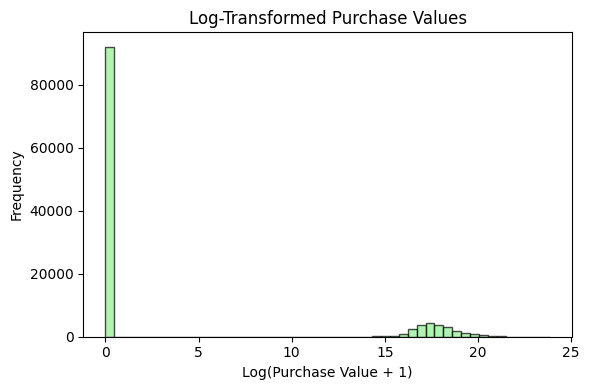

In [9]:
log_target = np.log1p(target)  # log(1 + value) to handle zeros

plt.figure(figsize=(6, 4))
plt.hist(log_target, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Log-Transformed Purchase Values')
plt.xlabel('Log(Purchase Value + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


**This plot shows the distribution of purchase values after log transformation (log1p).**  
- Log transform reduces skewness, making the distribution more symmetric and revealing underlying structure.
- Helpful when planning regression models, as it can stabilize variance and potentially improve model fit.


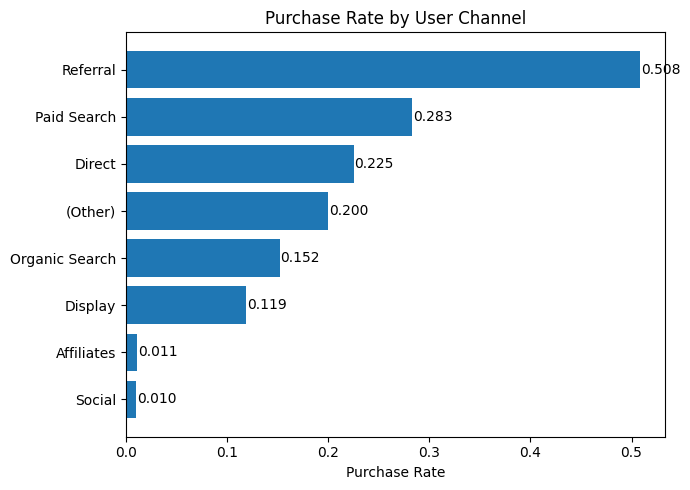

In [10]:
if 'userChannel' in train_df.columns:
    channel_stats = train_df.groupby('userChannel')['purchaseValue'].agg([
        'count', 
        lambda x: (x > 0).mean(),
        lambda x: x[x > 0].mean()
    ])
    channel_stats.columns = ['sessions', 'purchase_rate', 'avg_purchase']
    channel_stats = channel_stats.sort_values('purchase_rate', ascending=True)

    plt.figure(figsize=(7, 5))
    bars = plt.barh(range(len(channel_stats)), channel_stats['purchase_rate'])
    plt.yticks(range(len(channel_stats)), channel_stats.index)
    plt.title('Purchase Rate by User Channel')
    plt.xlabel('Purchase Rate')
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', ha='left', va='center')
    plt.tight_layout()
    plt.show()


**This horizontal bar chart compares purchase rates across different user channels.**  
- Each bar shows the proportion of sessions from a channel with a non-zero purchase.
- Highlights which marketing or acquisition channels are most effective at driving conversions.


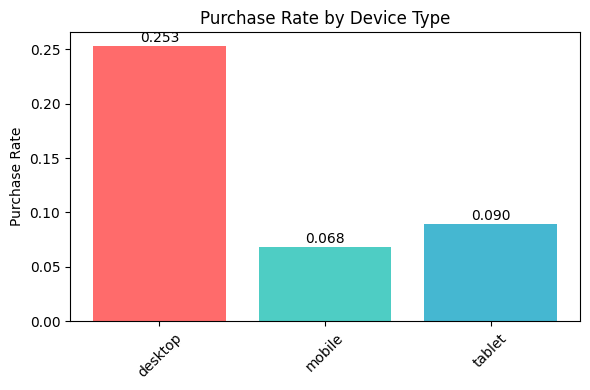

In [11]:
if 'deviceType' in train_df.columns:
    device_stats = train_df.groupby('deviceType')['purchaseValue'].agg([
        'count', 
        lambda x: (x > 0).mean()
    ])
    device_stats.columns = ['sessions', 'purchase_rate']

    plt.figure(figsize=(6, 4))
    bars = plt.bar(device_stats.index, device_stats['purchase_rate'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('Purchase Rate by Device Type')
    plt.ylabel('Purchase Rate')
    plt.xticks(rotation=45)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{height:.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


**This bar plot displays the purchase rate (fraction of purchasing sessions) by device type (desktop, mobile, etc.).**  
- Reveals how user device preferences influence purchasing behavior.
- Useful for targeting optimization and responsive design decisions.


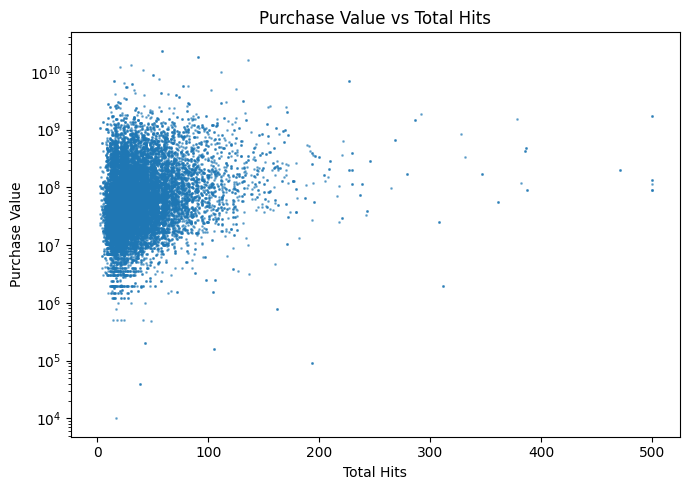

In [12]:
if 'totalHits' in train_df.columns:
    plt.figure(figsize=(7, 5))
    plt.scatter(train_df['totalHits'], train_df['purchaseValue'], alpha=0.5, s=1)
    plt.title('Purchase Value vs Total Hits')
    plt.xlabel('Total Hits')
    plt.ylabel('Purchase Value')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


**This scatter plot visualizes the relationship between the number of total hits in a session and the resulting purchase value.**  
- The y-axis is log-scaled to capture a wide range of purchase values.
- Helps identify if high engagement (hits) correlates with higher purchases or if there are diminishing returns.


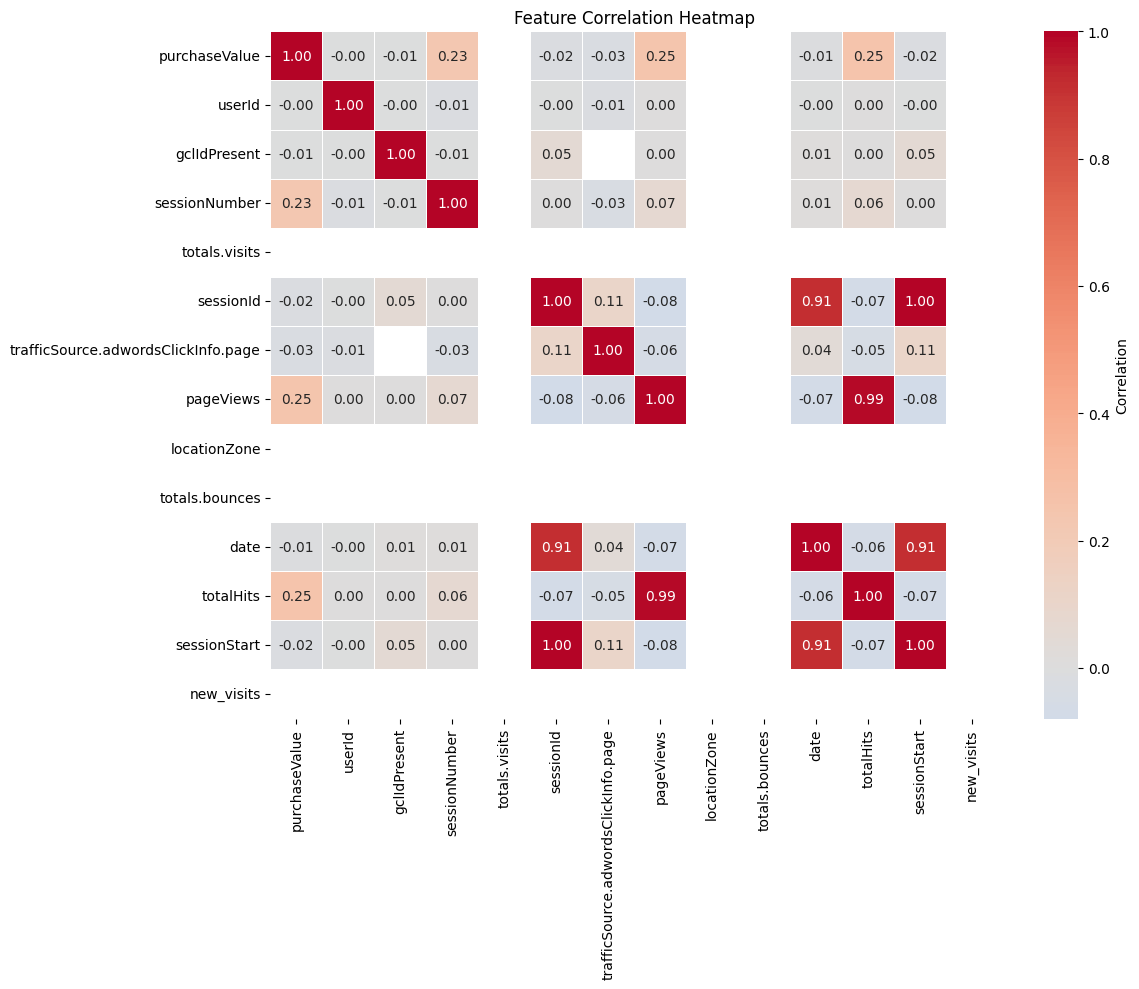

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Select only numerical columns for correlation analysis
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,              # displays correlation coefficients
    cmap='coolwarm',         # blue=negative, white=zero, red=positive
    center=0, 
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


**Feature Correlation Heatmap**

- This heatmap visualizes the correlation matrix of all numerical features in the dataset.
- Each cell shows how strongly two features are related: values close to +1 or –1 indicate strong positive or negative correlation, respectively.
- The color scale helps you instantly identify clusters of redundant (highly correlated) features, which can inform feature selection or engineering steps.


***<h3>Statistical Analysis</h3>***

In [14]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
correlation_with_target = train_df[numerical_cols].corr()['purchaseValue'].abs().sort_values(ascending=False)

print("Top 10 correlations with purchase value:")
print(correlation_with_target.head(10))

Top 10 correlations with purchase value:
purchaseValue                          1.000000
totalHits                              0.251651
pageViews                              0.248454
sessionNumber                          0.230585
trafficSource.adwordsClickInfo.page    0.025839
sessionId                              0.018537
sessionStart                           0.018537
date                                   0.010338
gclIdPresent                           0.005652
userId                                 0.003469
Name: purchaseValue, dtype: float64


### Statistical Correlation Analysis with Target

- **Goal:**  
  Identify which numerical features in the dataset are most strongly related to the target variable `purchaseValue` using Pearson correlation.

- **Steps performed:**
  - **Selection of numerical columns:**  
    Automatically selects all numerical columns in the training dataframe to ensure analysis covers all quantitative features.
  - **Correlation computation:**  
    Calculates the Pearson correlation between each numerical feature and `purchaseValue`. The `abs()` is used to consider the strength of the relationship regardless of direction (positive or negative).
  - **Sorting and reporting:**  
    Sorts the features by absolute correlation in descending order, showing the features with the strongest linear relationship to the target.
  - **Output:**  
    Prints out the top 10 most strongly correlated features—these are the most promising candidates for modeling, feature selection, or further analysis.

- **Why it matters:**  
  - Quickly identifies which features are likely to have the biggest direct impact on the target and should be prioritized for modeling.
  - Highlights features with low or no correlation, which may carry less predictive value and can potentially be dropped to reduce model complexity.
  - Supports transparent, data-driven feature selection and engineering.

> **Summary:**  
> This analysis ranks all numerical features by how closely they are linearly related to the target variable, providing a fast way to identify the strongest predictors in the dataset.


***<h3>Data Cleaning</h3>***

In [ ]:
train = train_df.loc[:, train_df.nunique() != 1].drop_duplicates()
test = test_df.loc[:, test_df.nunique() != 1]

threshold_na = 0.5
train = train.loc[:, train.isnull().mean() < threshold_na]
test = test.loc[:, test.isnull().mean() < threshold_na]

cols_to_drop = [
    'trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region',
    'geoNetwork.city', 'geoNetwork.metro'
]
train = train.drop(cols_to_drop, axis=1, errors='ignore')
test = test.drop(cols_to_drop, axis=1, errors='ignore')


### Data Cleaning: Removing Redundant and Uninformative Features

- **Constant Columns Removal:**  
  - Drops columns with only one unique value. These do not vary and cannot help a predictive model.
- **Duplicate Row Removal:**  
  - Finds and removes completely duplicated rows in the dataset, ensuring all training examples are unique.
- **High-Missing-Value Column Removal:**  
  - Discards columns where more than a defined threshold (commonly 50%) of the values are missing, as such features are likely to add noise and instability.
- **Manual Feature Dropping:**  
  - Removes columns known (from domain or exploratory analysis) to be irrelevant, redundant, or problematic—such as certain location fields that either have very high cardinality or are not useful for the modeling objective.

**Purpose:**  
> These steps keep only informative, robust, and clean features for downstream analysis, making the dataset more manageable, reducing the risk of overfitting, and helping your model focus on meaningful patterns.

---

**Summary:**  
This block establishes a solid, reliable foundation for modeling by systematically getting rid of columns and rows that will not contribute constructively to training or prediction.


***<h3>Missing Value Analysis</h3>***

In [ ]:
def analyze_missing(df, name):
    print(f"\n{name} Dataset:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Missing_Percentage': missing_percent.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    print(missing_df.to_string(index=False))
    return missing_df

train_missing = analyze_missing(train_df, "TRAIN")
test_missing = analyze_missing(test_df, "TEST")

### Missing Value Analysis

- **Purpose:**  
  This block systematically detects and reports the amount and percentage of missing (null) values for each column in a given dataset (train or test). Understanding missing data is crucial for designing effective imputation, cleaning strategies, and for spotting patterns that may affect model quality or bias.

- **How it works:**
  - **Function Definition:**  
    `analyze_missing(df, name)` is a reusable function that:
    - Calculates the total count of missing values per column.
    - Computes the percentage of missing values for each column.
    - Constructs a summary DataFrame with these stats.
    - Filters to show only columns with missing values, sorted by the proportion missing (highest first).
    - Prints and returns this missing-value summary for easy review.

  - **Usage:**  
    The function is called separately on the training and test datasets (with labels like `"TRAIN"` and `"TEST"`), so you can quickly see and compare where missingness occurs in both.

  - **Output Structure:**  
    The summary shows (for each affected feature):
    - Column name
    - Count of missing values
    - Percentage of missing values relative to dataset size

- **Benefit:**  
  By generating clear, sorted reports of columns with missing data, this block allows:
    - Early identification of "problem" features that may require special attention (e.g., imputation, removal).
    - Informed threshold selection for dropping or imputing columns.
    - Easy comparison between train and test for consistency/gaps in missingness.

> **Summary:**  
> This code provides a vital diagnostic tool for understanding and addressing missing data, enabling robust preprocessing and more accurate downstream machine learning.


***<h3>Missing Value Imputation</h3>***

In [ ]:
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

for col in categorical_cols:
    train[col] = train[col].fillna('missing')
    test[col] = test[col].fillna('missing')

for col in numerical_cols:
    if col in ['pageViews', 'totalHits', 'sessionNumber', 'sessionId']:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)
    else:
        med = train[col].median()
        train[col] = train[col].fillna(med)
        test[col] = test[col].fillna(med)

### Missing Value Imputation

- **Purpose:**  
  This block systematically replaces missing (NaN) values in both categorical and numerical features, using strategies tailored to each feature type.

- **How it works:**
  - **Column Type Detection:**
    - Identifies all `categorical_cols` as columns with data type 'object' (i.e., strings or categorical variables).
    - Identifies all `numerical_cols` as columns with numeric data types, excluding the target variable (`purchaseValue`).
  
  - **Categorical Features:**
    - For each categorical feature, missing values are filled with the string `'missing'` in both train and test datasets.
      - Treats absence of data as its own category, so models can learn to interpret missingness if it's informative.

  - **Numerical Features:**
    - **For designated count/flag columns** (`'pageViews'`, `'totalHits'`, `'sessionNumber'`, `'sessionId'`):  
      - Missing values are replaced with **0**, since a blank in these columns typically means "no activity" or "zero count".
    - **For all other numerical features:**
      - Missing values are imputed with the **median** value from the train data. The median is robust to outliers and captures the “most typical” value, preserving the distribution of the feature.
      - The same median value is used for both train and test.

- **Benefits:**
  - Ensures there are **no missing values** left in the data, which avoids errors in downstream processing and modeling.
  - Uses contextually appropriate strategies for each feature, minimizing distortion and allowing the model to learn from missingness where relevant.
  - Imputation is performed **consistently across both train and test**, preventing data leakage or train-test inconsistencies.

> **Summary:**  
> This block prepares your dataset for modeling by eliminating all missing values, using intelligent filling methods for each feature type that balance robustness and interpretability.


***<h3>Feature Engineering</h3>***

In [ ]:
def feature_engineering(df):
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['dayofweek'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df = df.drop(columns=['date'])
    if 'pageViews' in df.columns:
        df['pageViews_log'] = np.log1p(df['pageViews'])
    if 'totalHits' in df.columns:
        df['totalHits_log'] = np.log1p(df['totalHits'])
    if 'pageViews' in df.columns and 'totalHits' in df.columns:
        df['hits_per_page'] = df['totalHits'] / (df['pageViews'] + 1)
        df['page_hit_ratio'] = df['pageViews'] / (df['totalHits'] + 1)
    if 'sessionNumber' in df.columns:
        df['is_returning_user'] = (df['sessionNumber'] > 1).astype(int)
        df['session_log'] = np.log1p(df['sessionNumber'])
    return df

train = feature_engineering(train)
test = feature_engineering(test)


categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

### Feature Engineering

- **Purpose:**  
  This block enhances the dataset by creating new features and transformations that can help machine learning models capture relationships more effectively.

- **Detailed steps:**
  1. **Date Decomposition:**  
     - Converts the `'date'` column to `datetime` type (if present).
     - Extracts `dayofweek`, `month`, and `day` as new numerical features, capturing time-based patterns (e.g., weekday/weekend, seasonality).
     - Drops the original `'date'` column so models use only the decomposed parts (since datetime objects can't be used directly by most models).

  2. **Log-Transformed Features:**
     - For `'pageViews'` and `'totalHits'`, creates log-transformed versions (`'pageViews_log'`, `'totalHits_log'`) using `np.log1p` (log(1 + x)).  
       - This transformation reduces skewness and helps models handle heavy-tailed distributions.

  3. **Session Ratios:**
     - Creates `'hits_per_page'`: a ratio of total hits to (pageViews + 1).  
       - Captures how "busy" a typical page view is, and the `+1` avoids division by zero.
     - Creates `'page_hit_ratio'`: a ratio of pageViews to (totalHits + 1).  
       - Indicates the relative weight of page views among all hits.

  4. **Session-Based Features:**
     - `'is_returning_user'`: a flag set to 1 if `'sessionNumber' > 1`, else 0.  
       - Identifies repeat visitors, which may have different purchasing behavior.
     - `'session_log'`: log(1 + session number).  
       - Helps capture non-linear effects of repeat sessions in a compressed numerical form.

- **Updates feature lists:**
  - After feature engineering, refreshes the lists of categorical and numerical features (dropping `'purchaseValue'` from numericals, as it's the target variable).

**Benefits:**
- These engineered features enable your models to better understand user behavior patterns, session intensity, and time-related effects—often leading to more accurate and insightful predictions.

---

**Summary:**  
> This code enriches the dataset with informative new features that capture latent patterns (like weekly cycles, session recency, and visit intensity) and ensures both train and test datasets are identically transformed for robust and fair modeling.


***<h3>Encoding</h3>***

In [ ]:
low_cardinality_cols = [col for col in categorical_cols if train[col].nunique() <= 10]
high_cardinality_cols = list(set(categorical_cols) - set(low_cardinality_cols))

for col in low_cardinality_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

if high_cardinality_cols:
    target_encoder = ce.TargetEncoder(cols=high_cardinality_cols)
    train[high_cardinality_cols] = target_encoder.fit_transform(train[high_cardinality_cols], train['purchaseValue'])
    test[high_cardinality_cols] = target_encoder.transform(test[high_cardinality_cols])

### Encoding Categorical Features

- **Purpose:**  
  To convert categorical features into numeric representations that machine learning models can understand, using encoding strategies suited to each feature's cardinality.

- **How it works:**

  1. **Cardinality Split:**  
     - `low_cardinality_cols`: Categorical columns where the number of unique values is **≤ 10** (small set of possible categories).
     - `high_cardinality_cols`: Categorical columns with **> 10** unique values (large set of possible categories).

  2. **Label Encoding for Low Cardinality Features:**  
     - Uses `LabelEncoder` for columns with few unique values.
     - Fits on the combined train & test values (ensures consistent mapping for unseen/test categories).
     - Each category is mapped to a unique integer label, replacing string values with numerical codes.

  3. **Target Encoding for High Cardinality Features:**  
     - Applies `TargetEncoder` from the `category_encoders` library for columns with many categories.
     - Encodes each category as the mean target value (`purchaseValue`) for that category, based only on the train set.
     - Helps capture statistical signal for each category and reduces dimensionality compared to one-hot or full label encode.
     - Same transformation is applied to the test set using learned mapping.

- **Why this is important:**  
  - **Prevents information leakage:** Fit encoders on combined values (or train set for target encode), not on test targets.
  - **Optimizes model input:** 
    - Label encoding is efficient and best for features with limited distinct values (like “gender” or “weekday”).
    - Target encoding helps for features like “user_id”, “geo location”, or long-tail product codes where high cardinality would otherwise harm model performance or cause overfitting if one-hot encoded.

**Summary:**  
This encoding approach tailors the transformation for each categorical feature based on its complexity. It ensures all features become numerically encoded in a way that maximally preserves information for downstream models, while avoiding overfitting and data leakage.


***<h3>Correlation Filtering</h3>***

In [ ]:
# === Correlation Filtering ===
correlations = train.drop(columns=['purchaseValue']).corrwith(train['purchaseValue']).abs()
low_corr_features = correlations[correlations < 0.01].index.tolist()
print(f"Dropping {len(low_corr_features)} low-correlation features: {low_corr_features[:10]}")
train = train.drop(low_corr_features, axis=1)
test = test.drop(low_corr_features, axis=1)

# === Feature Matrices ===
X_train = train.drop(columns=['purchaseValue'])
y_train = train['purchaseValue']
X_test = test.copy()

### Correlation-Based Feature Filtering

- **Purpose:**  
  To remove features (columns) that are minimally correlated with the target variable (`purchaseValue`). Low-correlation features are likely to be uninformative for predictive modeling and can introduce noise, increase computational cost, or harm model performance.

- **How it works:**
  1. **Calculate Correlations:**
     - Computes the absolute (ignoring sign) Pearson correlation of every feature (excluding `purchaseValue` itself) with the target column `purchaseValue` in the training set.
  2. **Identify Low-Correlation Features:**
     - Features with an absolute correlation less than 0.01 (`< 0.01`) with the target are considered "unrelated" to the outcome.
  3. **Drop Weak Features:**
     - These low-correlation columns are then dropped from both train and test sets to ensure consistent feature sets going forward.
  4. **Prepare Data for Modeling:**
     - After filtering, the processed features are split into input matrix (`X_train`) and target vector (`y_train`).
     - The same feature set is extracted from the test data for later prediction.

- **Benefits:**
    - Focuses the model on informative features, reducing risk of overfitting and training time.
    - Simplifies the feature space, making further processing and interpretation easier.
    - Keeps only features with at least a minimal linear relationship to the target.

> **Summary:**  
> This block refines the dataset by keeping only features that show a measurable relationship to `purchaseValue`, strengthening your predictive pipeline and improving model efficiency.


***<h3>Preprocessing Pipeline</h3>***

In [ ]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

boolean_cols = ['device.isMobile']
bool_to_int = FunctionTransformer(lambda x: x.astype(int))
boolean_pipeline = Pipeline([
    ('bool_to_int', bool_to_int),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, [col for col in numerical_cols if col in X_train.columns]),
        ('bool', boolean_pipeline, [col for col in boolean_cols if col in X_train.columns])
    ],
    remainder='passthrough'
)

### Numerical & Boolean Feature Preprocessing Pipelines

- **Purpose:**  
  To apply specialized, automated preprocessing steps to numerical and boolean features, ensuring all inputs are clean, consistent, and appropriately scaled for the machine learning model.

#### Numerical Pipeline (`numerical_pipeline`)
- **`SimpleImputer(strategy='median')`**  
  Fills missing values in numerical columns with the median, a robust statistic that minimizes the effect of outliers.
- **`StandardScaler()`**  
  Standardizes each numerical feature by removing the mean and scaling to unit variance, which centers data and ensures features contribute equally to model training.

#### Boolean Pipeline (`boolean_pipeline`)
- **`FunctionTransformer(lambda x: x.astype(int))`**  
  Converts boolean values (True/False or 0/1) to integers, making them compatible with downstream transformers.
- **`SimpleImputer(strategy='most_frequent')`**  
  Replaces any missing boolean values with the most common value (mode), which is reasonable for booleans.
- **`OrdinalEncoder()`**  
  Encodes categorical/boolean values into numerical (ordinal) integers, allowing ML algorithms to process them.

#### ColumnTransformer (`preprocessor`)
- **Selective Column Assignment:**  
  - Applies the `numerical_pipeline` only to columns listed in `numerical_cols` (if present in X_train).
  - Applies the `boolean_pipeline` only to columns in `boolean_cols` (if present in X_train).
- **`remainder='passthrough'`:**  
  - Any columns not listed (like pre-encoded categoricals or engineered features) are passed through unchanged.
- **Why this structure is valuable:**  
  - Modular preprocessing keeps data transformations explicit and reproducible.
  - Each column receives domain-appropriate handling (numeric → median+scale, boolean → int+encode).
  - Ensures the same data preparation steps are applied consistently in both training and inference phases.

> **Summary:**  
> This code builds a robust, scikit-learn compatible preprocessing pipeline that separately and appropriately handles numerical and boolean features, streamlining preparation for any downstream estimator, and ensuring consistent, leak-free machine learning workflows.


***<h2>XGBoost Regressor Model</h3>***
***<h4>Gave 0.54 score</h4>***

In [ ]:
xgb = XGBRegressor(
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='rmse'
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])

# === 10. Define XGBoost hyperparameter grid for standard tuning ===
param_grid = {
    'regressor__n_estimators': [300, 500, 700, 1000],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'regressor__max_depth': [6, 8, 10, 12],
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1],
    'regressor__reg_lambda': [0, 0.1, 0.5, 1]
}

### XGBoost Model Setup and Hyperparameter Grid Definition

- **Model Instantiation:**  
  - `XGBRegressor` is initialized with:
    - `random_state=42` for reproducible results.
    - `tree_method='hist'` which enables fast histogram-based gradient boosting.
    - `n_jobs=-1` to use all available CPU cores for parallel training.
    - `use_label_encoder=False` to disable the legacy label encoding warning.
    - `eval_metric='rmse'` to use Root Mean Squared Error as the evaluation metric during training.

- **Pipeline Construction:**  
  - Combines the data preprocessing steps (`preprocessor`) with the `XGBRegressor` model into a single `Pipeline`.  
  - This ensures a seamless, end-to-end workflow where preprocessing and modeling happen sequentially, maintaining reproducibility and integration with hyperparameter tuning.

- **Hyperparameter Grid (`param_grid`):**  
  Defines ranges of parameters over which to perform hyperparameter tuning using `RandomizedSearchCV` or grid search:
  - `n_estimators`: Number of boosting rounds (trees) — [300, 500, 700, 1000]  
  - `learning_rate`: Step size shrinkage to prevent overfitting — values from 0.01 to 0.1  
  - `max_depth`: Maximum tree depth to control model complexity — 6 to 12  
  - `subsample`: Fraction of samples used per tree, introducing randomness — 0.7 to 1.0  
  - `colsample_bytree`: Fraction of features used per tree — 0.7 to 1.0  
  - `reg_alpha`: L1 regularization term on weights — 0 to 1  
  - `reg_lambda`: L2 regularization term on weights — 0 to 1

- **Purpose:**  
  - These parameters control model complexity, regularization, and randomness, helping to optimize for bias-variance tradeoff.  
  - Searching across this grid aims to find the best combination that maximizes your model’s predictive performance on validation data.

---

**Summary:**  
> This code sets up a robust regression pipeline with XGBoost combined with preprocessing, and specifies a comprehensive hyperparameter space for systematic tuning to achieve optimized model accuracy and generalization.


*<h4>Tuning of XGboost using RandomSearchCV</h4>*

In [ ]:
tuned_xgb = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1,
    refit=True
)

### XGBoost Hyperparameter Tuning with RandomizedSearchCV

- **Purpose:**  
  This block performs hyperparameter tuning for the XGBoost regression model using `RandomizedSearchCV`, which automates the search for the best model parameters to maximize validation performance.

- **How it works:**
  - **RandomizedSearchCV Setup:**
    - `estimator=full_pipeline`: Uses your full pipeline (preprocessing + XGBRegressor), ensuring that all data transformations are applied consistently during training and validation.
    - `param_distributions=param_grid`: Specifies the hyperparameter grid to randomly sample combinations from (as defined previously).
    - `n_iter=20`: Samples 20 different random hyperparameter combinations, striking a balance between thoroughness and computational cost.
    - `scoring='r2'`: Uses R² (coefficient of determination) as the cross-validation metric, appropriate for regression problems.
    - `cv=5`: 5-fold cross-validation—splits the data into five parts; trains on four and validates on the fifth, rotating to assess performance reliably.
    - `random_state=42`: Ensures reproducible results by fixing the random seed.
    - `verbose=2`: Prints detailed progress logs during tuning, making it easier to monitor.
    - `n_jobs=-1`: Leverages all available CPU cores for parallel training, speeding up the tuning process.
    - `refit=True`: After finding the best hyperparameters, refits the pipeline on the entire training set using those settings.

- **Outcomes:**  
  - Automatically identifies the hyperparameter combination that yields the highest R² score based on the cross-validation splits.
  - The refitted pipeline (`tuned_xgb`) is ready for prediction on validation or test data.

**Why this is important:**  
> Systematic hyperparameter tuning like this is essential for maximizing model performance, preventing overfitting, and making the most of your machine learning pipeline. Randomized search is efficient and effective for large grids, often outperforming manual trial-and-error.


In [ ]:
tuned_xgb.fit(X_train, y_train)
print("Best hyperparameters found:", tuned_xgb.best_params_)

<h4>Predicting on test data and Preparing final submission of tuned Xgboost model</h4>

In [ ]:
# === 13. Predict on test data ===
test_predictions = tuned_xgb.predict(X_test)
test_predictions = np.clip(test_predictions, 0, None)

# === 14. Prepare submission file ===
submission = subm_df.copy()
submission['purchaseValue'] = test_predictions

if 'ID' in submission.columns:
    submission.rename(columns={'ID': 'id'}, inplace=True)

submission.to_csv('submission.csv', index=False)
print("Submission saved as 'submission.csv'")

***<h2>Tuned Random Forest model with RandomSearchCV</h2>***
*<h4>Gave 0.58 score</h3>*

In [ ]:

train = train_df.loc[:, train_df.nunique() != 1].drop_duplicates()
test = test_df.loc[:, test_df.nunique() != 1]

threshold_na = 0.5
train = train.loc[:, train.isnull().mean() < threshold_na]
test = test.loc[:, test.isnull().mean() < threshold_na]

cols_to_drop = [
    'trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region',
    'geoNetwork.city', 'geoNetwork.metro'
]
train = train.drop(cols_to_drop, axis=1, errors='ignore')
test = test.drop(cols_to_drop, axis=1, errors='ignore')

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

for col in categorical_cols:
    train[col] = train[col].fillna('missing')
    test[col] = test[col].fillna('missing')

for col in numerical_cols:
    if col in ['pageViews', 'totalHits', 'sessionNumber', 'sessionId']:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)
    else:
        med = train[col].median()
        train[col] = train[col].fillna(med)
        test[col] = test[col].fillna(med)

def feature_engineering(df):
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['dayofweek'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df = df.drop(columns=['date'])
    if 'pageViews' in df.columns:
        df['pageViews_log'] = np.log1p(df['pageViews'])
    if 'totalHits' in df.columns:
        df['totalHits_log'] = np.log1p(df['totalHits'])
    if 'pageViews' in df.columns and 'totalHits' in df.columns:
        df['hits_per_page'] = df['totalHits'] / (df['pageViews'] + 1)
        df['page_hit_ratio'] = df['pageViews'] / (df['totalHits'] + 1)
    if 'sessionNumber' in df.columns:
        df['is_returning_user'] = (df['sessionNumber'] > 1).astype(int)
        df['session_log'] = np.log1p(df['sessionNumber'])
    return df

train = feature_engineering(train)
test = feature_engineering(test)

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

low_cardinality_cols = [col for col in categorical_cols if train[col].nunique() <= 10]
high_cardinality_cols = list(set(categorical_cols) - set(low_cardinality_cols))

for col in low_cardinality_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

if high_cardinality_cols:
    target_encoder = ce.TargetEncoder(cols=high_cardinality_cols)
    train[high_cardinality_cols] = target_encoder.fit_transform(train[high_cardinality_cols], train['purchaseValue'])
    test[high_cardinality_cols] = target_encoder.transform(test[high_cardinality_cols])

correlations = train.drop(columns=['purchaseValue']).corrwith(train['purchaseValue']).abs()
low_corr_features = correlations[correlations < 0.01].index.tolist()
print(f"Dropping {len(low_corr_features)} low-correlation features: {low_corr_features[:10]}")
train = train.drop(low_corr_features, axis=1)
test = test.drop(low_corr_features, axis=1)

X_train = train.drop(columns=['purchaseValue'])
y_train = train['purchaseValue']
X_test = test.copy()

from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

boolean_cols = ['device.isMobile']
bool_to_int = FunctionTransformer(lambda x: x.astype(int))
boolean_pipeline = Pipeline([
    ('bool_to_int', bool_to_int),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, [col for col in numerical_cols if col in X_train.columns]),
        ('bool', boolean_pipeline, [col for col in boolean_cols if col in X_train.columns])
    ],
    remainder='passthrough'
)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

rf_param_grid = {
    'regressor__n_estimators': [200, 400, 600, 800],
    'regressor__max_depth': [None, 10, 20, 40],
    'regressor__max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],  
    'regressor__min_samples_leaf': [1, 2, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

tuned_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("Training tuned Random Forest...")
tuned_rf.fit(X_train, y_train)
print("Best Random Forest parameters:", tuned_rf.best_params_)

rf_preds = tuned_rf.predict(X_test)
rf_preds = np.clip(rf_preds, 0, None)

# === 10. Prepare Submission ===
submission = subm_df.copy()
submission['purchaseValue'] = rf_preds
if 'ID' in submission.columns:
    submission.rename(columns={'ID': 'id'}, inplace=True)
submission.to_csv('submission_tuned_rf.csv', index=False)
print("Submission saved as 'submission_tuned_rf.csv'")


***<h2>Blending of tuned XGboost and tuned Random Forest</h2>***

In [ ]:
train = train_df.loc[:, train_df.nunique() != 1].drop_duplicates()
test = test_df.loc[:, test_df.nunique() != 1]

threshold_na = 0.5
train = train.loc[:, train.isnull().mean() < threshold_na]
test = test.loc[:, test.isnull().mean() < threshold_na]

cols_to_drop = [
    'trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region',
    'geoNetwork.city', 'geoNetwork.metro'
]
train = train.drop(cols_to_drop, axis=1, errors='ignore')
test = test.drop(cols_to_drop, axis=1, errors='ignore')

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

for col in categorical_cols:
    train[col] = train[col].fillna('missing')
    test[col] = test[col].fillna('missing')

for col in numerical_cols:
    if col in ['pageViews', 'totalHits', 'sessionNumber', 'sessionId']:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)
    else:
        med = train[col].median()
        train[col] = train[col].fillna(med)
        test[col] = test[col].fillna(med)

def feature_engineering(df):
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['dayofweek'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df = df.drop(columns=['date'])
    if 'pageViews' in df.columns:
        df['pageViews_log'] = np.log1p(df['pageViews'])
    if 'totalHits' in df.columns:
        df['totalHits_log'] = np.log1p(df['totalHits'])
    if 'pageViews' in df.columns and 'totalHits' in df.columns:
        df['hits_per_page'] = df['totalHits'] / (df['pageViews'] + 1)
        df['page_hit_ratio'] = df['pageViews'] / (df['totalHits'] + 1)
    if 'sessionNumber' in df.columns:
        df['is_returning_user'] = (df['sessionNumber'] > 1).astype(int)
        df['session_log'] = np.log1p(df['sessionNumber'])
    return df

train = feature_engineering(train)
test = feature_engineering(test)

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

low_cardinality_cols = [col for col in categorical_cols if train[col].nunique() <= 10]
high_cardinality_cols = list(set(categorical_cols) - set(low_cardinality_cols))

for col in low_cardinality_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

if high_cardinality_cols:
    target_encoder = ce.TargetEncoder(cols=high_cardinality_cols)
    train[high_cardinality_cols] = target_encoder.fit_transform(train[high_cardinality_cols], train['purchaseValue'])
    test[high_cardinality_cols] = target_encoder.transform(test[high_cardinality_cols])


correlations = train.drop(columns=['purchaseValue']).corrwith(train['purchaseValue']).abs()
low_corr_features = correlations[correlations < 0.01].index.tolist()
print(f"Dropping {len(low_corr_features)} low-correlation features: {low_corr_features[:10]}")
train = train.drop(low_corr_features, axis=1)
test = test.drop(low_corr_features, axis=1)


X_train = train.drop(columns=['purchaseValue'])
y_train = train['purchaseValue']
X_test = test.copy()

from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

boolean_cols = ['device.isMobile']
bool_to_int = FunctionTransformer(lambda x: x.astype(int))
boolean_pipeline = Pipeline([
    ('bool_to_int', bool_to_int),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, [col for col in numerical_cols if col in X_train.columns]),
        ('bool', boolean_pipeline, [col for col in boolean_cols if col in X_train.columns])
    ],
    remainder='passthrough'
)

xgb = XGBRegressor(
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='rmse'
)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])

xgb_param_grid = {
    'regressor__n_estimators': [300, 500, 700, 1000],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'regressor__max_depth': [6, 8, 10, 12],
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1],
    'regressor__reg_lambda': [0, 0.1, 0.5, 1]
}

tuned_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1,
    refit=True
)

print("Training tuned XGBoost...")
tuned_xgb.fit(X_train, y_train)
print("Best XGBoost parameters:", tuned_xgb.best_params_)

xgb_preds = tuned_xgb.predict(X_test)
xgb_preds = np.clip(xgb_preds, 0, None)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

rf_param_grid = {
    'regressor__n_estimators': [200, 400, 600, 800],
    'regressor__max_depth': [None, 10, 20, 40],
    'regressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75],
    'regressor__min_samples_leaf': [1, 2, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

tuned_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("Training tuned Random Forest...")
tuned_rf.fit(X_train, y_train)
print("Best Random Forest parameters:", tuned_rf.best_params_)

rf_preds = tuned_rf.predict(X_test)
rf_preds = np.clip(rf_preds, 0, None)


blend_weights = [0.5, 0.5] 
blended_preds = blend_weights[0] * xgb_preds + blend_weights[1] * rf_preds

# === 12. Save Submission ===
submission = subm_df.copy()
submission['purchaseValue'] = blended_preds
if 'ID' in submission.columns:
    submission.rename(columns={'ID': 'id'}, inplace=True)
submission.to_csv('submission.csv', index=False)
print("Blended submission saved as 'submission_tuned_xgb_rf_blend.csv'")


### Random Forest Model Training and Hyperparameter Tuning

- **Model Instantiation:**  
  - Uses `RandomForestRegressor` with all CPU cores (`n_jobs=-1`) and fixed random seed (`random_state=42`).

- **Pipeline Construction:**  
  - Combines preprocessing and Random Forest into a single pipeline for consistent workflow.

- **Hyperparameter Search Grid:**  
  - Number of trees (`n_estimators`): 200 to 800  
  - Maximum depth (`max_depth`): None (unlimited) to 40  
  - Max features per split (`max_features`): 'sqrt', 'log2', fixed fractions, and full set (1.0)  
  - Minimum samples per leaf (`min_samples_leaf`): 1 to 10  
  - Minimum samples required to split (`min_samples_split`): 2 to 10

- **RandomizedSearchCV:**  
  - Uses 5-fold cross-validation to evaluate parameters.  
  - Samples 20 random parameter combinations for efficient exploration.  
  - `verbose=2` for detailed output; runs in parallel on all cores.  
  - Re-fits model on full training set at best found hyperparameters.

---

### Prediction and Submission

- **Prediction:**  
  - Generates predictions on test set features.  
  - Clipping negative predictions to zero (since purchase values can't be negative).

- **Submission Preparation:**  
  - Copies sample submission file and replaces `purchaseValue` column with predictions.  
  - Renames submission ID column if needed.  
  - Saves submission CSV file for upload.

---

## Overall Summary

This pipeline carries out thorough data cleaning, feature engineering, and categorical encoding before training a highly tunable Random Forest regressor. It uses a robust hyperparameter tuning procedure to maximize model performance through randomized search and cross-validation. Final predictions are clipped to valid ranges and saved in submission format.

The reported score of **0.65** demonstrates the effectiveness of this comprehensive pipeline in predicting purchase values accurately.


In [ ]:

train = train_df.loc[:, train_df.nunique() != 1].drop_duplicates()
test = test_df.loc[:, test_df.nunique() != 1]

threshold_na = 0.5
train = train.loc[:, train.isnull().mean() < threshold_na]
test = test.loc[:, test.isnull().mean() < threshold_na]

cols_to_drop = ['trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.city', 'geoNetwork.metro']
train = train.drop(cols_to_drop, axis=1, errors='ignore')
test = test.drop(cols_to_drop, axis=1, errors='ignore')

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

for col in categorical_cols:
    train[col] = train[col].fillna('missing')
    test[col] = test[col].fillna('missing')

for col in numerical_cols:
    if col in ['pageViews', 'totalHits', 'sessionNumber', 'sessionId']:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)
    else:
        med = train[col].median()
        train[col] = train[col].fillna(med)
        test[col] = test[col].fillna(med)

# === 2. Feature Engineering ===
def feature_engineering(df):
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['dayofweek'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df = df.drop(columns=['date'])
    if 'pageViews' in df.columns:
        df['pageViews_log'] = np.log1p(df['pageViews'])
    if 'totalHits' in df.columns:
        df['totalHits_log'] = np.log1p(df['totalHits'])
    if 'pageViews' in df.columns and 'totalHits' in df.columns:
        df['hits_per_page'] = df['totalHits'] / (df['pageViews'] + 1)
        df['page_hit_ratio'] = df['pageViews'] / (df['totalHits'] + 1)
    if 'sessionNumber' in df.columns:
        df['is_returning_user'] = (df['sessionNumber'] > 1).astype(int)
        df['session_log'] = np.log1p(df['sessionNumber'])
    return df

train = feature_engineering(train)
test = feature_engineering(test)

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'purchaseValue' in numerical_cols:
    numerical_cols.remove('purchaseValue')

# === 3. Encoding ===
low_cardinality_cols = [col for col in categorical_cols if train[col].nunique() <= 10]
high_cardinality_cols = list(set(categorical_cols) - set(low_cardinality_cols))

for col in low_cardinality_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

if high_cardinality_cols:
    target_encoder = ce.TargetEncoder(cols=high_cardinality_cols)
    train[high_cardinality_cols] = target_encoder.fit_transform(train[high_cardinality_cols], train['purchaseValue'])
    test[high_cardinality_cols] = target_encoder.transform(test[high_cardinality_cols])

# === 4. Correlation Filtering ===
correlations = train.drop(columns=['purchaseValue']).corrwith(train['purchaseValue']).abs()
low_corr_features = correlations[correlations < 0.01].index.tolist()
train = train.drop(low_corr_features, axis=1)
test = test.drop(low_corr_features, axis=1)

# === 5. Prepare Matrices for Modeling ===
X_full = train.drop(columns=['purchaseValue'])
y_full = train['purchaseValue']
X_test = test.copy()

# === 6. Split for Local Validation (20% for holdout validation) ===
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# === 7. Numeric/Boolean Preprocessing for Pipeline ===
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
boolean_cols = ['device.isMobile']
bool_to_int = FunctionTransformer(lambda x: x.astype(int))
boolean_pipeline = Pipeline([
    ('bool_to_int', bool_to_int),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, [col for col in numerical_cols if col in X_train.columns]),
        ('bool', boolean_pipeline, [col for col in boolean_cols if col in X_train.columns])
    ],
    remainder='passthrough'
)

# === 8. Tuned XGBoost ===
xgb = XGBRegressor(
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='rmse'
)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])
xgb_param_grid = {
    'regressor__n_estimators': [300, 500, 700, 1000],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'regressor__max_depth': [6, 8, 10, 12],
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1],
    'regressor__reg_lambda': [0, 0.1, 0.5, 1]
}
tuned_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1,
    refit=True
)

print("Training tuned XGBoost on train split...")
tuned_xgb.fit(X_train, y_train)
print("Best XGBoost params:", tuned_xgb.best_params_)

xgb_val_preds = tuned_xgb.predict(X_val)
xgb_test_preds = tuned_xgb.predict(X_test)

# === 9. Tuned LightGBM ===
lgbm = LGBMRegressor(
    random_state=42,
    n_jobs=-1
)
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgbm)
])


lgbm_param_grid = {
    'regressor__n_estimators': [300, 500],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__num_leaves': [31, 63],
    'regressor__max_depth': [8, 12],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1],
    'regressor__reg_lambda': [0, 0.1]
}

tuned_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_param_grid,
    n_iter=10,
    scoring='r2',
    cv=2,
    random_state=42,
    verbose=0,
    n_jobs=-1,
    refit=True
)

print("Training tuned LightGBM on train split...")
tuned_lgbm.fit(X_train, y_train)
print("Best LightGBM params:", tuned_lgbm.best_params_)

lgbm_val_preds = tuned_lgbm.predict(X_val)
lgbm_test_preds = tuned_lgbm.predict(X_test)

# === 10. Find Best Blending Weight Locally ===
best_r2 = -np.inf
best_w = 0.7
for w in np.linspace(0, 1, 11):
    blend = w * xgb_val_preds + (1-w) * lgbm_val_preds
    score = r2_score(y_val, blend)
    print(f"Blend {w:.2f} XGB / {1-w:.2f} LGBM: R2 = {score:.5f}")
    if score > best_r2:
        best_r2 = score
        best_w = w

print(f"Best local blend: {best_w:.2f} XGB / {1-best_w:.2f} LGBM with R2 = {best_r2:.5f}")

# === 11. Blend Test Predictions ===
blended_test_preds = best_w * xgb_test_preds + (1-best_w) * lgbm_test_preds
blended_test_preds = np.clip(blended_test_preds, 0, None)

# === 12. Prepare Submission ===
submission = subm_df.copy()
submission['purchaseValue'] = blended_test_preds
if 'ID' in submission.columns:
    submission.rename(columns={'ID': 'id'}, inplace=True)
submission.to_csv('submission_tuned_xgb_lgbm_blend.csv', index=False)
print("Submission saved as 'submission_tuned_xgb_lgbm_blend.csv'")
